<a href="https://colab.research.google.com/github/prakharbanga/AIPlane3/blob/main/AIPlane3_ProGAN_%2B_Spectral_Norm_(256x256).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q clu

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
import jax
import jax.numpy as jnp
from jax.tree_util import tree_flatten
from flax import linen as nn, struct
from flax.training import train_state
from flax.core import frozen_dict
from flax.serialization import (to_state_dict, msgpack_serialize, from_bytes)
import optax
from clu import metrics
import functools
import numpy as np
from PIL import Image
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt
from typing import Any, Optional
import glob
import os
import IPython.display as display
import shutil
import time
import math

In [ ]:
assert tf.test.gpu_device_name() == "/device:GPU:0", "GPU not found!"
print(f"Found {jax.device_count()} devices of type {jax.devices()[0].device_kind}")

num_devices = jax.device_count()
device_type = jax.devices()[0].device_kind

print(f"Found {num_devices} JAX devices of type {device_type}.")
!nvidia-smi
# assert "TPU" in device_type, "Available device is not a TPU, please select TPU from Edit > Notebook settings > Hardware accelerator"

Found 1 devices of type Tesla T4
Found 1 JAX devices of type Tesla T4.
Sat Aug 26 22:13:16 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   54C    P0    27W /  70W |    389MiB / 15360MiB |      6%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                 

In [ ]:
def image_to_input(image):
  return 2. * image / 255. - 1.

def input_to_image(input):
  return (input + 1.) * 255. / 2.

## Download FGVC Aircraft Dataset

In [ ]:
# !wget -nc https://www.robots.ox.ac.uk/~vgg/data/fgvc-aircraft/archives/fgvc-aircraft-2013b.tar.gz

In [ ]:
# !mkdir /content/fgvc-aircraft-2013b/
# if not glob.glob("fgvc-aircraft-2013b/fgvc-aircraft-2013b/data/images"):
#   !tar -xkf "/content/fgvc-aircraft-2013b.tar.gz" -C "/content/fgvc-aircraft-2013b/"     #[run this cell to extract tar files]

In [ ]:
# !mkdir -p fgvc-aircraft-2013b-4/fgvc-aircraft-2013b/data/images

# for image_file in glob.glob("fgvc-aircraft-2013b/fgvc-aircraft-2013b/data/images/*.jpg"):
#   new_image_file = "fgvc-aircraft-2013b-4/" + "/".join(image_file.split('/')[1:])
#   if glob.glob(new_image_file):
#     continue
#   with Image.open(image_file) as image:
#     image.resize((4, 4)).save(new_image_file)

In [ ]:
# !tar -czf fgvc-aircraft-2013b-4.tar.gz fgvc-aircraft-2013b-4/fgvc-aircraft-2013b

In [ ]:
!wget -nc https://storage.googleapis.com/prak345/fgvc-aircraft-2013b-256.tar.gz
!wget -nc https://storage.googleapis.com/prak345/fgvc-aircraft-2013b-128.tar.gz
!wget -nc https://storage.googleapis.com/prak345/fgvc-aircraft-2013b-64.tar.gz
!wget -nc https://storage.googleapis.com/prak345/fgvc-aircraft-2013b-32.tar.gz
!wget -nc https://storage.googleapis.com/prak345/fgvc-aircraft-2013b-16.tar.gz
!wget -nc https://storage.googleapis.com/prak345/fgvc-aircraft-2013b-8.tar.gz
!wget -nc https://storage.googleapis.com/prak345/fgvc-aircraft-2013b-4.tar.gz

File ‘fgvc-aircraft-2013b-256.tar.gz’ already there; not retrieving.

File ‘fgvc-aircraft-2013b-128.tar.gz’ already there; not retrieving.

File ‘fgvc-aircraft-2013b-64.tar.gz’ already there; not retrieving.

File ‘fgvc-aircraft-2013b-32.tar.gz’ already there; not retrieving.

File ‘fgvc-aircraft-2013b-16.tar.gz’ already there; not retrieving.

File ‘fgvc-aircraft-2013b-8.tar.gz’ already there; not retrieving.

File ‘fgvc-aircraft-2013b-4.tar.gz’ already there; not retrieving.



In [ ]:
!mkdir -p /content/fgvc-aircraft-2013b-256/
if not glob.glob("fgvc-aircraft-2013b-256/fgvc-aircraft-2013b/data/images"):
  !tar -xkf "/content/fgvc-aircraft-2013b-256.tar.gz"     #[run this cell to extract tar files]

!mkdir -p /content/fgvc-aircraft-2013b-128/
if not glob.glob("fgvc-aircraft-2013b-128/fgvc-aircraft-2013b/data/images"):
  !tar -xkf "/content/fgvc-aircraft-2013b-128.tar.gz"     #[run this cell to extract tar files]

!mkdir -p /content/fgvc-aircraft-2013b-64/
if not glob.glob("fgvc-aircraft-2013b-64/fgvc-aircraft-2013b/data/images"):
  !tar -xkf "/content/fgvc-aircraft-2013b-64.tar.gz"     #[run this cell to extract tar files]

!mkdir -p /content/fgvc-aircraft-2013b-32/
if not glob.glob("fgvc-aircraft-2013b-32/fgvc-aircraft-2013b/data/images"):
  !tar -xkf "/content/fgvc-aircraft-2013b-32.tar.gz"     #[run this cell to extract tar files]

!mkdir -p /content/fgvc-aircraft-2013b-16/
if not glob.glob("fgvc-aircraft-2013b-16/fgvc-aircraft-2013b/data/images"):
  !tar -xkf "/content/fgvc-aircraft-2013b-16.tar.gz"     #[run this cell to extract tar files]

!mkdir -p /content/fgvc-aircraft-2013b-8/
if not glob.glob("fgvc-aircraft-2013b-8/fgvc-aircraft-2013b/data/images"):
  !tar -xkf "/content/fgvc-aircraft-2013b-8.tar.gz"     #[run this cell to extract tar files]

!mkdir -p /content/fgvc-aircraft-2013b-4/
if not glob.glob("fgvc-aircraft-2013b-4/fgvc-aircraft-2013b/data/images"):
  !tar -xkf "/content/fgvc-aircraft-2013b-4.tar.gz"     #[run this cell to extract tar files]

In [ ]:
def concat(dss):
  return functools.reduce(lambda x, y: x.concatenate(y), dss)

def split_dataset(dataset, *args):
  cumsplits = np.cumsum(args).tolist()
  total = cumsplits[-1]
  return [concat([dataset.shard(total, split) for split in range(start, end)]) for (start, end) in zip([0] + cumsplits, cumsplits)]

def get_datasets(num_epochs, batch_sizes):
  sample_fn = lambda sample: image_to_input(tf.cast(sample, tf.float32))
  dss = []
  first_fn = (lambda x, y: x)
  for (resindex, resolution) in enumerate([4, 8, 16, 32, 64, 128, 256]):
    (train, test) = split_dataset(tf.keras.utils.image_dataset_from_directory(f"/content/fgvc-aircraft-2013b-{resolution}", image_size=(resolution, resolution), batch_size=batch_sizes[resindex]), 90, 10)
    # 256x256 dataset doesn't fit in memory/cache and crashes the runtime.
    dss.append(((train.map(first_fn).map(sample_fn).cache() if resolution <= 128 else train.map(first_fn).map(sample_fn).cache(f"cache_res{resolution}_{int(time.time())}")).repeat(num_epochs).prefetch(tf.data.AUTOTUNE),
               test.map(first_fn).map(sample_fn).cache().prefetch(tf.data.AUTOTUNE)))
  return dss

In [ ]:
num_epochs = 10_000_000
batch_sizes = [64, 64, 64, 64, 64, 64, 64]
if 'datasets' not in globals():
  datasets = get_datasets(num_epochs, batch_sizes)
assert len(batch_sizes) == len(datasets)
for (idx, test_ds) in enumerate(np.array(datasets)[:,1]):
  for batch in test_ds.as_numpy_iterator():
    assert batch.shape[1:] == (4 * 2 ** idx, 4 * 2 ** idx, 3), f"Batch shape is {batch.shape}"
print(f"Test dataset size: {sum([batch.shape[0] for batch in datasets[3][1].as_numpy_iterator()])}")

Found 10000 files belonging to 1 classes.
Found 10000 files belonging to 1 classes.
Found 10000 files belonging to 1 classes.
Found 10000 files belonging to 1 classes.
Found 10000 files belonging to 1 classes.
Found 10000 files belonging to 1 classes.
Found 10000 files belonging to 1 classes.
Test dataset size: 640


In [ ]:
REAL_LABEL = 0
FAKE_LABEL = 1

In [ ]:
def gridify(grid):
  num = grid.shape[0]
  height = grid[0].shape[0]
  width = grid[0].shape[1]
  col = math.ceil(math.sqrt(num))
  row = col-1 if col*(col-1) >= num else col
  padded = np.concatenate([grid, np.zeros([row*col-num]+list(grid[0].shape))], axis=0)
  return np.transpose(padded.reshape((row, col, height, width, 3)), axes=(0, 2, 1, 3, 4)).reshape(row*height, col*width, 3)

for dataset in datasets[::-1]:
  elems = list(dataset[0].take(1).get_single_element())
  display.display(Image.fromarray(input_to_image(gridify(np.array([elem.numpy() for elem in elems]))).astype(np.uint8)))

## Spectral Norm Module (borrowed from Haiku)

In [ ]:
# Original Source: https://github.com/deepmind/dm-haiku/blob/main/haiku/_src/spectral_norm.py

def _l2_normalize(x, axis=None, eps=1e-12):
  """Normalizes along dimension `axis` using an L2 norm.

  This specialized function exists for numerical stability reasons.

  Args:
    x: An input ndarray.
    axis: Dimension along which to normalize, e.g. `1` to separately normalize
      vectors in a batch. Passing `None` views `t` as a flattened vector when
      calculating the norm (equivalent to Frobenius norm).
    eps: Epsilon to avoid dividing by zero.

  Returns:
    An array of the same shape as 'x' L2-normalized along 'axis'.
  """
  return x * jax.lax.rsqrt((x * x).sum(axis=axis, keepdims=True) + eps)


class SpectralNorm(nn.Module):
  """Normalizes an input by its first singular value.

  This module uses power iteration to calculate this value based on the
  input and an internal hidden state.

  update_stats: A boolean defaulting to True. Regardless of this arg, this
    function will return the normalized input. When
    `update_stats` is True, the internal state of this object will also be
    updated to reflect the input value. When `update_stats` is False the
    internal stats will remain unchanged.
  error_on_non_matrix: Spectral normalization is only defined on matrices.
    By default, this module will return scalars unchanged and flatten
    higher-order tensors in their leading dimensions. Setting this flag to
    True will instead throw errors in those cases.

  """

  wrapped: nn.Module
  update_stats: bool = True
  error_on_non_matrix: bool = False
  eps: float = 1e-4
  n_steps: int = 1

  @nn.compact
  def __call__(
      self,
      value: jax.Array
  ) -> jax.Array:
    """Wraps a layer with Spectral Normalization.

    Args:
      value: The value (Array-like) for which you would like to perform an
        spectral normalization after the wrapped layer.
    Returns:
      The output of the wrapped layer normalized by it's first singular value.
    Raises:
      ValueError: If `error_on_non_matrix` is True and `value` has ndims > 2.
    """

    u0 = self.variable(
        'spectral_norm_stats', 'u0', lambda s: jnp.ones(s, jnp.float32), (1, self.wrapped.features)
    )

    if 'params' not in self.wrapped.variables or 'kernel' not in self.wrapped.variables['params']:
      return self.wrapped(value)

    kernel = self.wrapped.variables['params']['kernel']

    # Handle scalars.
    if kernel.ndim <= 1:
      raise ValueError("Spectral normalization is not well defined for "
                       "scalar or vector inputs.")
    # Handle higher-order tensors.
    elif kernel.ndim > 2:
      if self.error_on_non_matrix:
        raise ValueError(
            f"Input is {kernel.ndim}D but error_on_non_matrix is True")
      else:
        kernel = jnp.reshape(kernel, [-1, kernel.shape[-1]])

    u0_val = u0.value

    # Power iteration for the weight's singular value.
    for _ in range(self.n_steps):
      v0_val = _l2_normalize(jnp.matmul(u0_val, kernel.transpose([1, 0])), eps=self.eps)
      u0_val = _l2_normalize(jnp.matmul(v0_val, kernel), eps=self.eps)

    u0_val = jax.lax.stop_gradient(u0_val)
    v0_val = jax.lax.stop_gradient(v0_val)

    sigma = jnp.matmul(jnp.matmul(v0_val, kernel), jnp.transpose(u0_val))[0, 0]

    if self.update_stats:
      u0.value = u0_val

    return self.wrapped(value) / (sigma + 1e-8)

## End of Spectral Norm

## Local Response Normalization

In [ ]:
class LocalResponseNorm(nn.Module):
  @nn.compact
  def __call__(
      self,
      value: jax.Array
  ) -> jax.Array:
    return value / jnp.repeat(jnp.expand_dims((1e-8 + (value**2).mean(axis=-1))**0.5, axis=-1), repeats=value.shape[-1], axis=-1)

## End of Local Response Normalization

In [ ]:
EPSILON = 1e-8
MAX_DISC_FEATURES = 128
MAX_GEN_FEATURES = 512
LATENT_DIM = 512
MAX_LAYERS = 7 # 256x256

def get_disc_layers(layer, name_suffix=""):
  resolution = int(4 * 2 ** layer)
  features = min(int(32 * 2 ** (MAX_LAYERS - 1 - layer)), MAX_DISC_FEATURES)
  layers = []
  layers.append(lambda x, training: jax.image.resize(x, shape=(x.shape[0], resolution, resolution, x.shape[3]), method="linear"))
  layers.append(lambda x, training: SpectralNorm(nn.Conv(features=features, kernel_size=(3, 3), name=f"Conv_{resolution}_{features}{name_suffix}"), update_stats=training, name=f"SN_{resolution}_{features}{name_suffix}")(x))
  layers.append(lambda x, training: nn.leaky_relu(x, negative_slope=0.2))
  return layers

def get_final_disc_layers():
  features = min(int(32 * 2 ** (MAX_LAYERS - 1)), MAX_DISC_FEATURES)
  layers = []
  layers.append(lambda x, training: SpectralNorm(nn.Conv(features=features, kernel_size=(4, 4), padding="VALID", name=f"Conv_1_{features}"), update_stats=training, name=f"SN_1_{features}")(x))
  layers.append(lambda x, training: x.reshape((x.shape[0], -1)))
  layers.append(lambda x, training: SpectralNorm(nn.Dense(features=1, name="Dense"), update_stats=training, name="SN_Dense")(x))
  layers.append(lambda x, training: nn.tanh(x))
  return layers

class Discriminator(nn.Module):
  num_layers: int = None

  def setup(self):
    # 256x256x3 => 256x256x32 => 128x128x64 => 64x64x128 => 32x32x128 => 16x16x128 => 8x8x128 => 4x4x128 => 1x1x128 => 1x1x1
    layers = []
    for layer in range(self.num_layers-1, -1, -1):
      layers.extend(get_disc_layers(layer))
    layers.extend(get_final_disc_layers())
    self.layers = layers

  @nn.compact
  def __call__(self, x, training=True):
    result = x
    for layer in self.layers:
      result = layer(result, training)
    return result

class TransitionDiscriminator(nn.Module):
  num_layers: int = None

  def setup(self):
    large_layers = []
    large_layers.extend(get_disc_layers(self.num_layers-1))
    large_layers.extend(get_disc_layers(self.num_layers-2, "_large"))

    small_layers = []
    small_layers.extend(get_disc_layers(self.num_layers-2))

    combined_layers = []
    for layer in range(self.num_layers-3, -1, -1):
      combined_layers.extend(get_disc_layers(layer))
    combined_layers.extend(get_final_disc_layers())

    self.large_layers = large_layers
    self.small_layers = small_layers
    self.combined_layers = combined_layers

  @nn.compact
  def __call__(self, large, small, alpha, training=True):
    large_result = large
    for layer in self.large_layers:
      large_result = layer(large_result, training)

    small_result = small
    for layer in self.small_layers:
      small_result = layer(small_result, training)

    result = alpha * small_result + (1-alpha) * large_result
    for layer in self.combined_layers:
      result = layer(result, training)

    return result


def get_gen_layers(layer):
  resolution = int(4 * 2 ** layer)
  features = min(int(32 * 2 ** (MAX_LAYERS - 1 - layer)), MAX_GEN_FEATURES)
  layers = []
  layers.append(lambda x: jax.image.resize(x, shape=(x.shape[0], resolution, resolution, x.shape[3]), method="linear"))
  layers.append(lambda x: nn.ConvTranspose(features=features, kernel_size=(3, 3), name=f"ConvTranspose_{resolution}_{features}")(x))
  layers.append(lambda x: nn.relu(x))
  return layers

def get_initial_gen_layers(num_layers):
  layers = []
  layers.append(lambda x: x.reshape(x.shape[0], 1, 1, -1))
  return layers

def get_final_gen_layers(num_layers):
  resolution = int(4 * 2 ** (num_layers - 1))
  layers = []
  layers.append(lambda x: nn.ConvTranspose(features=3, kernel_size=(3, 3), name=f"ConvTranspose_{resolution}_3")(x))
  return layers

class Generator(nn.Module):
  num_layers: int = None

  def setup(self):
    # 512 => 1x1x512 => 4x4x512 => 8x8x512 => 16x16x512 => 32x32x256 => 64x64x128 => 128x128x64 => 256x256x32 => 256x256x3
    layers = []
    layers.extend(get_initial_gen_layers(self.num_layers))
    for layer in range(self.num_layers):
      layers.extend(get_gen_layers(layer))
    layers.extend(get_final_gen_layers(self.num_layers))
    self.layers = layers

  @nn.compact
  def __call__(self, x):
    result = x
    for layer in self.layers:
      result = layer(result)
    return result

class TransitionGenerator(nn.Module):
  num_layers: int = None

  def setup(self):
    combined_layers = []
    combined_layers.extend(get_initial_gen_layers(self.num_layers))
    for layer in range(self.num_layers-1):
      combined_layers.extend(get_gen_layers(layer))
    small_layers = []
    small_layers.extend(get_final_gen_layers(self.num_layers-1))
    large_layers = []
    large_layers.extend(get_gen_layers(self.num_layers-1))
    large_layers.extend(get_final_gen_layers(self.num_layers))

    self.large_layers = large_layers
    self.small_layers = small_layers
    self.combined_layers = combined_layers

  @nn.compact
  def __call__(self, x):
    result = x
    for layer in self.combined_layers:
      result = layer(result)
    small_result = result
    for layer in self.small_layers:
      small_result = layer(small_result)
    large_result = result
    for layer in self.large_layers:
      large_result = layer(large_result)
    return (large_result, small_result)

In [ ]:
discriminator = Discriminator(7)
generator = Generator(7)
transition_discriminator = TransitionDiscriminator(7)
transition_generator = TransitionGenerator(7)
print(discriminator.tabulate({'params': jax.random.PRNGKey(0)}, jnp.ones((10, 256, 256, 3)), console_kwargs={'width': 120}))
print(generator.tabulate({'params': jax.random.PRNGKey(0)}, jnp.zeros((10, LATENT_DIM)), console_kwargs={'width': 120}))
print(transition_discriminator.tabulate({'params': jax.random.PRNGKey(0)}, jnp.ones((10, 256, 256, 3)), jnp.ones((10, 128, 128, 3)), 0.5, console_kwargs={'width': 120}))
print(transition_generator.tabulate({'params': jax.random.PRNGKey(0)}, jnp.zeros((10, LATENT_DIM)), console_kwargs={'width': 120}))


                                                 Discriminator Summary                                                  
┏━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃ path        ┃ module        ┃ inputs              ┃ outputs              ┃ params              ┃ spectral_norm_stats ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│             │ Discriminator │ float32[10,256,256… │ float32[10,1]        │                     │                     │
├─────────────┼───────────────┼─────────────────────┼──────────────────────┼─────────────────────┼─────────────────────┤
│ SN_256_32   │ SpectralNorm  │ float32[10,256,256… │ float32[10,256,256,… │                     │ u0: float32[1,32]   │
│             │               │                     │                      │                     │                     │
│             │               │

In [ ]:
discriminator = Discriminator(1)
generator = Generator(1)
transition_discriminator = TransitionDiscriminator(2)
transition_generator = TransitionGenerator(2)
print(discriminator.tabulate({'params': jax.random.PRNGKey(0)}, jnp.ones((10, 4, 4, 3)), console_kwargs={'width': 120}))
print(generator.tabulate({'params': jax.random.PRNGKey(0)}, jnp.zeros((10, LATENT_DIM)), console_kwargs={'width': 120}))
print(transition_discriminator.tabulate({'params': jax.random.PRNGKey(0)}, jnp.ones((10, 8, 8, 3)), jnp.ones((10, 4, 4, 3)), 0.5, console_kwargs={'width': 120}))
print(transition_generator.tabulate({'params': jax.random.PRNGKey(0)}, jnp.zeros((10, LATENT_DIM)), console_kwargs={'width': 120}))


                                                 Discriminator Summary                                                  
┏━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃ path       ┃ module        ┃ inputs              ┃ outputs             ┃ params                ┃ spectral_norm_stats ┃
┡━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│            │ Discriminator │ float32[10,4,4,3]   │ float32[10,1]       │                       │                     │
├────────────┼───────────────┼─────────────────────┼─────────────────────┼───────────────────────┼─────────────────────┤
│ SN_4_128   │ SpectralNorm  │ float32[10,4,4,3]   │ float32[10,4,4,128] │                       │ u0: float32[1,128]  │
│            │               │                     │                     │                       │                     │
│            │               │ 

In [ ]:
@struct.dataclass
class DiscMetrics(metrics.Collection):
  accuracy: metrics.Accuracy
  loss: metrics.Average.from_output('loss')
  prediction: metrics.Average.from_output('prediction')

@struct.dataclass
class GenMetrics(metrics.Collection):
  accuracy: metrics.Accuracy
  loss: metrics.Average.from_output('loss')
  prediction: metrics.Average.from_output('prediction')

In [ ]:
class DiscriminatorTrainState(train_state.TrainState):
  metrics: DiscMetrics
  spectral_norm_stats: Any
  latent_key: jax.random.KeyArray

def merge_params(params, existing_params):
  result = {}
  for param_name in params.keys():
    if param_name + "_large" in existing_params.keys():
      result[param_name] = existing_params[param_name + "_large"]
    elif param_name in existing_params.keys():
      result[param_name] = existing_params[param_name]
    else:
      result[param_name] = params[param_name]
  return result

def create_disc_train_state(module, rng, optim, args_fn, existing_params, existing_spectral_norm_stats):
  main_key, params_key, latent_key = jax.random.split(rng, num=3)
  variables = module.init(params_key, *args_fn(main_key), training=False)
  params = merge_params(variables['params'], existing_params)
  spectral_norm_stats=merge_params(variables['spectral_norm_stats'], existing_spectral_norm_stats)
  return DiscriminatorTrainState.create(
      apply_fn=module.apply, params=params, spectral_norm_stats=spectral_norm_stats,
      tx=optim, latent_key=latent_key, metrics=DiscMetrics.empty())

class GeneratorTrainState(train_state.TrainState):
  metrics: GenMetrics
  latent_key: jax.random.KeyArray

def create_gen_train_state(module, rng, optim, arg_fn, existing_params):
  main_key, params_key, latent_key = jax.random.split(rng, num=3)
  variables = module.init(params_key, arg_fn(main_key))
  params = merge_params(variables['params'], existing_params)
  return GeneratorTrainState.create(
      apply_fn=module.apply, params=params, tx=optim,
      latent_key=latent_key, metrics=GenMetrics.empty())

In [ ]:
def sample_latent(batch_size, key):
  return jax.random.normal(key, shape=(batch_size, LATENT_DIM))

In [ ]:
NOISE_LEVEL = 0.10

@jax.jit
def disc_train_step(d_state, g_state, batch):

  def d_loss(d_params):
    d_latent_key = jax.random.fold_in(d_state.latent_key, d_state.step)
    g_out = g_state.apply_fn({'params': g_state.params}, sample_latent(batch.shape[0], d_latent_key))
    d_input = jnp.concatenate([batch, g_out], axis=0)
    (d_out, d_updates) = d_state.apply_fn({'params': d_params, 'spectral_norm_stats': d_state.spectral_norm_stats}, d_input, training=True, mutable=['spectral_norm_stats'])
    noise = int(batch.shape[0] * NOISE_LEVEL)
    d_loss = (d_out[:batch.shape[0]-noise].sum() - d_out[batch.shape[0]+noise:].sum() + d_out[batch.shape[0]:batch.shape[0]+noise].sum() - d_out[batch.shape[0]-noise:batch.shape[0]].sum()) / (2 * batch.shape[0])
    return (d_loss, d_updates)

  (d_loss, d_updates), d_grads = jax.value_and_grad(d_loss, has_aux=True)(d_state.params)

  return (
      d_state.apply_gradients(grads=d_grads).replace(spectral_norm_stats=d_updates['spectral_norm_stats'])
  )

@jax.jit
def disc_transition_train_step(d_state, g_state, batch_large, batch_small, alpha):

  def d_loss(d_params):
    d_latent_key = jax.random.fold_in(d_state.latent_key, d_state.step)
    (g_out_large, g_out_small) = g_state.apply_fn({'params': g_state.params}, sample_latent(batch.shape[0], d_latent_key))
    (d_input_large, d_input_small) = (jnp.concatenate([batch_large, g_out_large], axis=0), jnp.concatenate([batch_small, g_out_small], axis=0))
    (d_out, d_updates) = d_state.apply_fn({'params': d_params, 'spectral_norm_stats': d_state.spectral_norm_stats}, d_input_large, d_input_small, alpha, training=True, mutable=['spectral_norm_stats'])
    noise = int(batch.shape[0] * NOISE_LEVEL)
    d_loss = (d_out[:batch.shape[0]-noise].sum() - d_out[batch.shape[0]+noise:].sum() + d_out[batch.shape[0]:batch.shape[0]+noise].sum() - d_out[batch.shape[0]-noise:batch.shape[0]].sum()) / (2 * batch.shape[0])
    return (d_loss, d_updates)

  (d_loss, d_updates), d_grads = jax.value_and_grad(d_loss, has_aux=True)(d_state.params)

  return (
      d_state.apply_gradients(grads=d_grads).replace(spectral_norm_stats=d_updates['spectral_norm_stats'])
  )

@jax.jit
def gen_train_step(d_state, g_state, batch):

  def g_loss(g_params):
    g_latent_key = jax.random.fold_in(g_state.latent_key, g_state.step)
    g_out = g_state.apply_fn({'params': g_params}, sample_latent(batch.shape[0], g_latent_key))
    d_out_fake = d_state.apply_fn({'params': d_state.params, 'spectral_norm_stats': d_state.spectral_norm_stats}, g_out, training=False)
    return d_out_fake.mean()

  g_loss, g_grads = jax.value_and_grad(g_loss)(g_state.params)

  return (
      g_state.apply_gradients(grads=g_grads)
  )

@jax.jit
def gen_transition_train_step(d_state, g_state, alpha, batch):

  def g_loss(g_params):
    g_latent_key = jax.random.fold_in(g_state.latent_key, g_state.step)
    (g_out_large, g_out_small)  = g_state.apply_fn({'params': g_params}, sample_latent(batch.shape[0], g_latent_key))
    d_out_fake = d_state.apply_fn({'params': d_state.params, 'spectral_norm_stats': d_state.spectral_norm_stats}, g_out_large, g_out_small, alpha, training=False)
    return d_out_fake.mean()

  g_loss, g_grads = jax.value_and_grad(g_loss)(g_state.params)

  return (
      g_state.apply_gradients(grads=g_grads)
  )


In [ ]:
@jax.jit
def compute_metrics(d_state, g_state, batch):
  g_latent_key = jax.random.fold_in(g_state.latent_key, g_state.step)

  g_out = g_state.apply_fn({'params': g_state.params}, sample_latent(batch.shape[0], g_latent_key))
  d_out_real = d_state.apply_fn({'params': d_state.params, 'spectral_norm_stats': d_state.spectral_norm_stats}, batch, training=False)
  d_out_fake = d_state.apply_fn({'params': d_state.params, 'spectral_norm_stats': d_state.spectral_norm_stats}, g_out, training=False)

  avg_pred = jnp.concatenate([d_out_fake, d_out_real], axis=0).mean()

  d_logits = jnp.concatenate([jnp.concatenate([avg_pred-d_out_real, d_out_real-avg_pred], axis=1), jnp.concatenate([avg_pred-d_out_fake, d_out_fake-avg_pred], axis=1)], axis=0)
  d_labels = jnp.concatenate([jnp.repeat(a=REAL_LABEL, repeats=batch.shape[0]), jnp.repeat(a=FAKE_LABEL, repeats=batch.shape[0])]).astype(jnp.int32)
  g_logits = jnp.concatenate([avg_pred-d_out_fake, d_out_fake-avg_pred], axis=1)
  g_labels = jnp.repeat(a=REAL_LABEL, repeats=batch.shape[0]).astype(jnp.int32)

  d_loss = d_out_real.mean() - d_out_fake.mean()

  g_metric_updates = g_state.metrics.single_from_model_output(logits=g_logits, labels=g_labels, loss=d_out_fake.mean(), prediction=d_out_fake)
  d_metric_updates = d_state.metrics.single_from_model_output(logits=d_logits, labels=d_labels, loss=d_loss,
                                                              prediction=jnp.concatenate([d_out_real, d_out_fake]))
  return (
      d_state.replace(metrics=d_state.metrics.merge(d_metric_updates)),
      g_state.replace(metrics=g_state.metrics.merge(g_metric_updates))
  )

@jax.jit
def compute_metrics_transition(d_state, g_state, batch_large, batch_small, alpha):
  g_latent_key = jax.random.fold_in(g_state.latent_key, g_state.step)

  (g_out_large, g_out_small) = g_state.apply_fn({'params': g_state.params}, sample_latent(batch_large.shape[0], g_latent_key))
  d_out_real = d_state.apply_fn({'params': d_state.params, 'spectral_norm_stats': d_state.spectral_norm_stats}, batch_large, batch_small, alpha, training=False)
  d_out_fake = d_state.apply_fn({'params': d_state.params, 'spectral_norm_stats': d_state.spectral_norm_stats}, g_out_large, g_out_small, alpha, training=False)

  avg_pred = jnp.concatenate([d_out_fake, d_out_real], axis=0).mean()

  d_logits = jnp.concatenate([jnp.concatenate([avg_pred-d_out_real, d_out_real-avg_pred], axis=1), jnp.concatenate([avg_pred-d_out_fake, d_out_fake-avg_pred], axis=1)], axis=0)
  d_labels = jnp.concatenate([jnp.repeat(a=REAL_LABEL, repeats=batch.shape[0]), jnp.repeat(a=FAKE_LABEL, repeats=batch.shape[0])]).astype(jnp.int32)
  g_logits = jnp.concatenate([avg_pred-d_out_fake, d_out_fake-avg_pred], axis=1)
  g_labels = jnp.repeat(a=REAL_LABEL, repeats=batch.shape[0]).astype(jnp.int32)

  d_loss = d_out_real.mean() - d_out_fake.mean()

  g_metric_updates = g_state.metrics.single_from_model_output(logits=g_logits, labels=g_labels, loss=d_out_fake.mean(), prediction=d_out_fake)
  d_metric_updates = d_state.metrics.single_from_model_output(logits=d_logits, labels=d_labels, loss=d_loss,
                                                              prediction=jnp.concatenate([d_out_real, d_out_fake]))
  return (
      d_state.replace(metrics=d_state.metrics.merge(d_metric_updates)),
      g_state.replace(metrics=g_state.metrics.merge(g_metric_updates))
  )

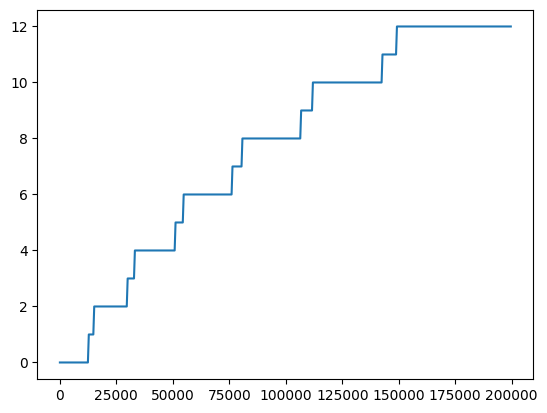

In [ ]:
INITIAL_STEPS = 12_500
TRANSITION = 0.2
MULTIPLIER = 1.2

transitions = []
all_steps = 0
steps = INITIAL_STEPS

transitions.append(0)

for layer in range(MAX_LAYERS-1):
  all_steps += int(steps)
  transitions.append(all_steps)
  all_steps += int(steps * TRANSITION)
  transitions.append(all_steps)
  steps *= MULTIPLIER

X = [400 * x for x in range(500)]
plt.plot(X, [np.searchsorted(transitions, x, 'right') - 1 for x in X])

In [ ]:
run_id = f'{int(time.time())}'
logdir = f'runs_{run_id}'
writer = SummaryWriter(logdir)
port = 6000 + int(time.time()) % 40
%load_ext tensorboard
%tensorboard --port={port} --logdir={logdir}

In [ ]:
num_steps_per_checkpoint = 500

for img in glob.glob("image*png"):
  os.remove(img)

for ckp in glob.glob("d_checkpoint_*.msgpack"):
  os.remove(ckp)

for ckp in glob.glob("g_checkpoint_*.msgpack"):
  os.remove(ckp)

latents = sample_latent(4, key=jax.random.PRNGKey(0))

skipped_train_steps = 0
skipped_test_steps = 0

step = -1
layer = None

d_state = None
g_state = None

In [ ]:
def small_batch(large_batch):
  return jax.image.resize(large_batch, shape=(large_batch.shape[0], int(large_batch.shape[1]/2), int(large_batch.shape[2]/2), large_batch.shape[3]), method="linear")

while step < 200_000:
  step += 1

  if step in transitions:
    layer = transitions.index(step)
    resindex = int((layer+1)/2)
    resolution = 4 * (2 ** resindex)

    existing_d_params = {}
    existing_spectral_norm_stats = {}
    if d_state:
      existing_d_params = d_state.params
      existing_spectral_norm_stats = d_state.spectral_norm_stats

    existing_g_params = {}
    if g_state:
      existing_g_params = g_state.params

    learning_rate = 1e-4 * batch_sizes[resindex] / 64
    if layer % 2 == 0:
      discriminator = Discriminator(1+resindex)
      generator = Generator(1+resindex)
      d_state = create_disc_train_state(discriminator, jax.random.PRNGKey(1), optax.rmsprop(learning_rate), lambda key: (jax.random.normal(key, shape=[6, resolution, resolution, 3]),), existing_d_params, existing_spectral_norm_stats)
      g_state = create_gen_train_state(generator, jax.random.PRNGKey(0), optax.rmsprop(learning_rate), lambda key: jax.random.normal(key, shape=(16, LATENT_DIM)), existing_g_params)
    else:
      discriminator = TransitionDiscriminator(1+resindex)
      generator = TransitionGenerator(1+resindex)
      d_state = create_disc_train_state(discriminator, jax.random.PRNGKey(1), optax.rmsprop(learning_rate), lambda key: (jax.random.normal(key, shape=[6, resolution, resolution, 3]), jax.random.normal(key, shape=[6, int(resolution/2), int(resolution/2), 3]), 1.), existing_d_params, existing_spectral_norm_stats)
      g_state = create_gen_train_state(generator, jax.random.PRNGKey(0), optax.rmsprop(learning_rate), lambda key: jax.random.normal(key, shape=(16, LATENT_DIM)), existing_g_params)

    ds_iter = datasets[resindex][0].as_numpy_iterator()

  if layer % 2 == 1:
    alpha = (transitions[layer+1] - step) / (transitions[layer+1] - transitions[layer])

  batch = ds_iter.next()

  if batch.shape[0] != batch_sizes[resindex]:
    # TODO: figure out how to drop_remainder with disk + TFDS dataset
    skipped_train_steps += 1
    continue

  if step % num_steps_per_checkpoint == 0:
    d_train_metrics = d_state.metrics
    d_state = d_state.replace(metrics=DiscMetrics.empty())

    g_train_metrics = g_state.metrics
    g_state = g_state.replace(metrics=GenMetrics.empty())

    # Take expensive model checkpoints rarely.
    if step % (5 * num_steps_per_checkpoint) == 0:
      with open(f'd_checkpoint_{step}.msgpack', 'wb') as outfile:
        outfile.write(msgpack_serialize(to_state_dict(d_state)))
      with open(f'g_checkpoint_{step}.msgpack', 'wb') as outfile:
        outfile.write(msgpack_serialize(to_state_dict(g_state)))

    d_test_state = d_state
    d_state = d_state.replace(metrics=DiscMetrics.empty())

    g_test_state = g_state
    g_state = g_state.replace(metrics=GenMetrics.empty())

    for test_batch in datasets[resindex][1].as_numpy_iterator():
      if test_batch.shape[0] != batch_sizes[resindex]:
        # TODO: figure out how to drop_remainder with disk + TFDS dataset
        skipped_test_steps += 1
        continue
      if layer % 2 == 0:
        d_test_state, g_test_state = compute_metrics(d_test_state, g_test_state, test_batch)
      else:
        d_test_state, g_test_state = compute_metrics_transition(d_test_state, g_test_state, test_batch, small_batch(test_batch), alpha)

    writer.add_scalars('Discriminator/Loss', {'train': d_train_metrics.loss.compute().tolist(), 'test': d_test_state.metrics.loss.compute().tolist()}, step)
    writer.add_scalars('Discriminator/Accuracy', {'train': d_train_metrics.accuracy.compute().tolist(), 'test': d_test_state.metrics.accuracy.compute().tolist()}, step)

    writer.add_scalars('Generator/Loss', {'train': g_train_metrics.loss.compute().tolist(), 'test': g_test_state.metrics.loss.compute().tolist()}, step)
    writer.add_scalars('Generator/Accuracy', {'train': g_train_metrics.accuracy.compute().tolist(), 'test': g_test_state.metrics.accuracy.compute().tolist()}, step)

    writer.add_scalars('Prediction/Discriminator', {'train': d_train_metrics.prediction.compute().tolist(), 'test': d_test_state.metrics.prediction.compute().tolist()}, step)
    writer.add_scalars('Prediction/Generator', {'train': g_train_metrics.prediction.compute().tolist(), 'test': g_test_state.metrics.prediction.compute().tolist()}, step)

    writer.add_scalars('Skipped Steps', {'train': skipped_train_steps, 'test': skipped_test_steps}, step)

    # To measure training walltime speed.
    writer.add_scalar('Steps', step, step)

    if layer % 2 == 1:
      writer.add_scalar('Resolution', alpha * resolution / 2 + (1 - alpha) * resolution, step)
    else:
      writer.add_scalar('Resolution', resolution, step)

    real = input_to_image(batch[:4]).astype(np.uint8)
    if layer % 2 == 0:
      g_out = generator.apply({'params': g_state.params}, latents)
      gen = np.array(input_to_image(g_out).astype(np.uint8))
      for (idx, img) in enumerate(gen):
        Image.fromarray(img).save(f"image{resolution}_{step}_{idx}.png", "PNG")
      writer.add_images(f"images{resolution}/real", real, step, dataformats='NHWC')
      writer.add_images(f"images{resolution}/generated", gen, step, dataformats='NHWC')
    else:
      real_small = np.array(small_batch(real).astype(np.uint8))
      (g_out_large, g_out_small) = generator.apply({'params': g_state.params}, latents)
      (gen_large, gen_small) = (np.array(input_to_image(g_out_large).astype(np.uint8)), np.array(input_to_image(g_out_small).astype(np.uint8)))
      for (idx, img) in enumerate(gen_large):
        Image.fromarray(img).save(f"image{resolution}_{step}_{idx}.png", "PNG")
      for (idx, img) in enumerate(gen_small):
        Image.fromarray(img).save(f"image{int(resolution/2)}_{step}_{idx}.png", "PNG")
      writer.add_images(f"images{resolution}/real", real, step, dataformats='NHWC')
      writer.add_images(f"images{int(resolution/2)}/real", real_small, step, dataformats='NHWC')
      writer.add_images(f"images{resolution}/generated", gen_large, step, dataformats='NHWC')
      writer.add_images(f"images{int(resolution/2)}/generated", gen_small, step, dataformats='NHWC')
    writer.add_scalar('Disk Usage (GiB)', shutil.disk_usage('.').used / (1024 * 1024 * 1024), step)

    writer.flush()

  if layer % 2 == 0:
    d_state = disc_train_step(d_state, g_state, batch)
    g_state = gen_train_step(d_state, g_state, batch)
    (d_state, g_state) = compute_metrics(d_state, g_state, batch)
  else:
    batch_small = small_batch(batch)
    d_state = disc_transition_train_step(d_state, g_state, batch, batch_small, alpha)
    g_state = gen_transition_train_step(d_state, g_state, alpha, batch)
    (d_state, g_state) = compute_metrics_transition(d_state, g_state, batch, batch_small, alpha)

In [ ]:
assert False # stop execution

AssertionError: ignored

In [ ]:
from google.colab import files

for fil in sorted(glob.glob("*checkpoint*"), key=lambda x: -int(x.split('_')[2].split('.')[0]))[:2]:
  files.download(fil)

In [ ]:
from google.colab import files

!tar -czf images_{run_id}.tar.gz image*png
files.download(f"images_{run_id}.tar.gz")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from google.colab import files

!tar -czf runs_{run_id}.tar.gz runs_{run_id}
files.download(f"runs_{run_id}.tar.gz")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
latents.shape

In [ ]:
!pip install -q ffmpegcv

In [ ]:
import cv2
import pandas as pd
import os
import ffmpegcv

# writer = ffmpegcv.VideoWriterNV(f"output_{run_id}.mp4", "hevc", 30, (512, 256))
writer = cv2.VideoWriter(f"output_{run_id}.mp4", cv2.VideoWriter_fourcc('M','J','P','G'), 30, (1024, 384))

images = glob.glob("image*png")
df = pd.DataFrame(images, columns=["filename"])
df["step"] = df.filename.map(lambda x: int(x.split("_")[1]))
df["size"] = df.filename.map(lambda x: int(x.split("_")[0][len("image"):]))
df["idx"] = df.filename.map(lambda x: int(x.split("_")[2].split(".")[0]))

sorted_grouped = df.sort_values(["step", "size", "idx"]).groupby("step")

def format_step(step):
  if step < 1000:
    return f"{step}"
  elif step < 1000000:
    return f"{step/1000:.2f}K"
  else:
    return f"{step/1000000:.2f}M"

sstep = -1
layer = None
for step, group in sorted_grouped:
  while sstep < step:
    sstep += 1
    if sstep in transitions:
      layer = transitions.index(sstep)
      resindex = int((layer+1)/2)
      resolution = 4 * (2 ** resindex)

  if layer % 2 == 1:
    alpha = (transitions[layer+1] - step) / (transitions[layer+1] - transitions[layer])

  footer1 = cv2.putText((255. * np.ones(shape=(64, 1024, 3))).astype(np.uint8), f"Step {format_step(step)}", org=(350, 44), fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=1.5, color=(0, 0, 0))
  if layer % 2 == 0:
    imgs = np.array(jax.image.resize(jnp.array([cv2.imread(fil) for fil in group[group["size"] == resolution]["filename"]] # 4 x resolution x resolution x 3
                    ), shape=(4, 256, 256, 3), method="linear")).transpose((1, 0, 2, 3)).reshape((256, 4*256, 3))
    footer2 = cv2.putText((255. * np.ones(shape=(64, 1024, 3))).astype(np.uint8), f"{resolution}x{resolution}", org=(300, 36), fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=1.5, color=(0, 0, 0))
  else:
    imgs_hi = np.array(jax.image.resize(jnp.array([cv2.imread(fil) for fil in group[group["size"] == resolution]["filename"]] # 4 x resolution x resolution x 3
                    ), shape=(4, 256, 256, 3), method="linear")).transpose((1, 0, 2, 3)).reshape((256, 4*256, 3))
    imgs_lo = np.array(jax.image.resize(jnp.array([cv2.imread(fil) for fil in group[group["size"] == int(resolution/2)]["filename"]] # 4 x resolution/2 x resolution/2 x 3
                    ), shape=(4, 256, 256, 3), method="linear")).transpose((1, 0, 2, 3)).reshape((256, 4*256, 3))
    imgs = ((1-alpha) * imgs_hi + alpha * imgs_lo).astype(np.uint8)
    footer2 = cv2.putText((255. * np.ones(shape=(64, 1024, 3))).astype(np.uint8), f"{resolution}x{resolution}: {1-alpha:.2f}  {int(resolution/2)}x{int(resolution/2)}: {alpha:.2f}  ", org=(300, 36), fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=1.5, color=(0, 0, 0))
  writer.write(np.concatenate([imgs, footer1, footer2]).astype(np.uint8))
writer.release()
files.download(f"output_{run_id}.mp4")
cv2.imwrite(f"generated_{run_id}.png", imgs)
files.download(f"generated_{run_id}.png")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import pickle

with open("latents.pickle", "wb") as f:
  pickle.dump(latents, f)

files.download("latents.pickle")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
sampled_latents = sample_latent(256, jax.random.PRNGKey(0))
(g_out128, g_out64, g_out32, g_out16, g_out8, g_out4) = generator.apply({'params': g_state.params, 'batch_stats': g_state.batch_stats}, sampled_latents, training=False)

In [ ]:
def gridify(grid):
  return np.transpose(grid.reshape((16, 16, 128, 128, 3)), axes=(0, 2, 1, 3, 4)).reshape(16*128, 16*128, 3)

display.display(Image.fromarray(input_to_image(gridify(np.array(g_out128))).astype(np.uint8)))

In [ ]:
display.display(Image.fromarray(input_to_image(np.array(g_out128[15*16+4])).astype(np.uint8)))